In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

from sklearn.metrics import r2_score

In [21]:
df = pd.read_csv('test_filtered_df.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20473 entries, 0 to 20472
Data columns (total 19 columns):
price            20473 non-null float64
bedrooms         20473 non-null int64
bathrooms        20473 non-null float64
sqft_living      20473 non-null int64
sqft_lot         20473 non-null int64
floors           20473 non-null float64
view             20473 non-null int64
condition        20473 non-null int64
grade            20473 non-null int64
sqft_above       20473 non-null int64
sqft_basement    20473 non-null float64
yr_built         20473 non-null int64
yr_renovated     20473 non-null int64
sqft_living15    20473 non-null int64
sqft_lot15       20473 non-null int64
basement         20473 non-null int64
year             20473 non-null int64
Renovated        20473 non-null int64
age_when_sold    20473 non-null int64
dtypes: float64(4), int64(15)
memory usage: 3.0 MB


In [3]:
num = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

In [4]:
for feat in num:
    df[feat] = np.log(df[feat])

C:\Users\damni\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,basement,year,Renovated,age_when_sold
0,221900.0,3,1.00,7.073270,8.639411,1.0,0,3,7,7.073270,-inf,1955,0,7.200425,8.639411,0,2014,0,59
1,538000.0,3,2.25,7.851661,8.887653,2.0,0,3,7,7.682482,5.991465,1951,1991,7.432484,8.941022,1,2014,1,63
2,180000.0,2,1.00,6.646391,9.210340,1.0,0,3,6,6.646391,-inf,1933,0,7.908387,8.994917,0,2015,0,82
3,604000.0,4,3.00,7.580700,8.517193,1.0,0,5,7,6.956545,6.813445,1965,0,7.215240,8.517193,1,2014,0,49
4,510000.0,3,2.00,7.426549,8.997147,1.0,0,3,8,7.426549,-inf,1987,0,7.495542,8.923058,0,2015,0,28


In [389]:
sk_ols = LinearRegression(fit_intercept=False, normalize=False, n_jobs=-1)

In [289]:
rfe = RFE(sk_ols, n_features_to_select=3, step=1, verbose=2)

In [219]:
X_all = df.drop(columns=['price', 'yr_renovated', 'yr_built', 'sqft_basement'])
rfe.fit(X_all, df['price'])

Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.


RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1,
                               normalize=False),
    n_features_to_select=4, step=1, verbose=2)

In [220]:
new_cols = X_all.columns[rfe.support_]

In [221]:
X_new = df[new_cols]
X_new.head()

,view,grade,basement,Renovated
0,0,7,0,0
1,0,7,1,1
2,0,6,0,0
3,0,7,1,0
4,0,8,0,0


In [390]:
def make_ols_sklearn(X, y, test_size=0.20, fit_intercept=False, standardize=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    if standardize:
        ss = StandardScaler()
        ss.fit(X_train)
        X_train = ss.transform(X_train)
        X_test = ss.transform(X_test)
    ols = LinearRegression(fit_intercept=fit_intercept, normalize=False)
    ols.fit(X_train, y_train)
    train_score = ols.score(X_train, y_train)
    test_score = ols.score(X_test, y_test)
    print(f"train score = {train_score}")
    print(f"test score = {test_score}")
    return ols

In [222]:
make_ols_sklearn(X_new, df['price'])

train score = 0.3304741533308696
test score = 0.3495466017444949


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [13]:
cv_scores = cross_val_score(sk_ols, X_new, df['price'], scoring='r2', cv=10, n_jobs=-1) 
cv_scores

array([0.42738539, 0.42592283, 0.40556966, 0.40503311, 0.431014  ,
       0.42176587, 0.43578731, 0.44268948, 0.43651462, 0.40361647])

In [14]:
target ='price'

In [15]:
train, test = train_test_split(df)

In [16]:
predictors = '+'.join(new_cols)
formula = target + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     2913.
Date:                Thu, 04 Jun 2020   Prob (F-statistic):               0.00
Time:                        10:19:45   Log-Likelihood:            -2.0800e+05
No. Observations:               15354   AIC:                         4.160e+05
Df Residuals:                   15348   BIC:                         4.161e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.628e+06   4.05e+04    -40.166      0.000   -1.71e+06   -1.55e+06
view           5.449e+04   2333.660     23.351      0.000    4.99e+04    5.91e+04
grade          1.285e+05   2001.195     64.225      0.000    1.25e+05    1.32e+05
sqft_living15   1.48e+05   6464.793     22.890      0.000    1.35e+05    1.61e+05
basement       7.059e+04   3119.111     22.631      0.000    6.45e+04    7.67e+04
Renovated      1.401e+05   8405.950     16.673      0.000    1.24e+05    1.57e+05
==============================================================================
Omnibus:                     4021.805   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14952.813
Skew:                           1.276   Prob(JB):                         0.00
Kurtosis:                       7.106   Cond. No.                         296.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [261]:
new_df = pd.read_csv('master_with_distances.csv')
new_df.head()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20097 entries, 0 to 20096
Data columns (total 18 columns):
price                            20097 non-null float64
bedrooms                         20097 non-null int64
bathrooms                        20097 non-null float64
sqft_living                      20097 non-null int64
sqft_lot                         20097 non-null int64
floors                           20097 non-null float64
view                             20097 non-null int64
condition                        20097 non-null int64
grade                            20097 non-null int64
sqft_above                       20097 non-null int64
yr_built                         20097 non-null int64
yr_renovated                     20097 non-null int64
zipcode                          20097 non-null int64
basement                         20097 non-null int64
Renovated                        20097 non-null int64
age_when_sold                    20097 non-null int64
distance_from_seattle

In [262]:
new_df = new_df.loc[(new_df['grade'] > 5)]
new_df = new_df.loc[(new_df['grade'] < 11)]
new_df = new_df.loc[(new_df['bathrooms'] > .8)]

In [263]:
new_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,basement,Renovated,age_when_sold,distance_from_seattle_km,distance_from_nearest_hotspot
count,1.968200e+04,19682.000000,19682.000000,19682.000000,19682.000000,19682.000000,19682.000000,19682.000000,19682.000000,19682.000000,19682.000000,19682.000000,19682.000000,19682.000000,19682.000000,19682.000000,19682.000000,19682.000000
mean,4.933526e+05,3.342343,2.062074,1982.807337,10259.867544,1.482039,0.170613,3.413271,7.569759,1703.625495,1970.862971,62.371761,98079.780663,0.387461,0.031247,43.458744,17.958787,10.863947
std,2.333510e+05,0.846759,0.685580,743.676912,12818.544832,0.540137,0.632724,0.641630,0.969132,692.867896,29.162703,347.310148,53.504908,0.487183,0.173989,29.163980,9.914163,5.689567
min,8.200000e+04,1.000000,1.000000,390.000000,520.000000,1.000000,0.000000,2.000000,6.000000,390.000000,1900.000000,0.000000,98001.000000,0.000000,0.000000,-1.000000,0.983428,0.754684
25%,3.200000e+05,3.000000,1.500000,1420.000000,5000.000000,1.000000,0.000000,3.000000,7.000000,1180.000000,1952.000000,0.000000,98033.000000,0.000000,0.000000,18.000000,9.706220,6.668990
50%,4.430000e+05,3.000000,2.250000,1870.000000,7388.000000,1.000000,0.000000,3.000000,7.000000,1520.000000,1974.000000,0.000000,98072.000000,0.000000,0.000000,40.000000,16.289887,9.716811
75%,6.149875e+05,4.000000,2.500000,2440.000000,10000.000000,2.000000,0.000000,4.000000,8.000000,2100.000000,1996.000000,0.000000,98118.000000,1.000000,0.000000,63.000000,24.675402,14.020587
max,1.500000e+06,6.000000,4.250000,4720.000000,138085.000000,3.500000,4.000000,5.000000,10.000000,4210.000000,2015.000000,2015.000000,98199.000000,1.000000,1.000000,115.000000,48.178198,30.913555


In [269]:
new_df['sqft_living'] = np.log(new_df['sqft_living'])
new_df['price'] = np.log(new_df['price'])
new_df['distance_from_seattle_km'] = np.log(new_df['distance_from_seattle_km'])
new_df['distance_from_nearest_hotspot'] = np.log(new_df['distance_from_nearest_hotspot'])

In [290]:
X_all = new_df.drop(columns=['price', 'yr_renovated', 'yr_built', 'bedrooms',  'view', 'floors', 'bathrooms', 'grade', 'condition', 'distance_from_seattle_km'])
rfe.fit(X_all, new_df['price'])

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.


RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1,
                               normalize=False),
    n_features_to_select=3, step=1, verbose=2)

In [291]:
new_cols = X_all.columns[rfe.support_]

In [292]:
X_new = new_df[new_cols]
X_new.head()

,sqft_living,Renovated,distance_from_nearest_hotspot
0,7.073270,0,2.662882
1,7.851661,1,2.288785
2,6.646391,0,2.311032
3,7.580700,0,2.291486
4,7.426549,0,1.540106


In [297]:
make_ols_sklearn(X_new, new_df['price'])

train score = -0.2733632268480721
test score = -0.3524148362667973


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [298]:
cv_scores = cross_val_score(sk_ols, X_new, new_df['price'], scoring='r2', cv=10, n_jobs=-1) 
cv_scores

array([0.59748135, 0.56518662, 0.56828166, 0.58980553, 0.55893527,
       0.59507818, 0.58223192, 0.58962051, 0.59377302, 0.64159581])

In [295]:
X = new_df[new_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(new_cols, vif))

[('sqft_living', 17.948837263113074),
 ('Renovated', 1.0374943905511491),
 ('distance_from_nearest_hotspot', 17.820449114175386)]

In [223]:
X_all = new_df.drop(columns=['price', 'yr_renovated', 'yr_built', 'bedrooms',  'view', 'floors', 'bathrooms', 'grade', 'condition'])
rfe.fit(X_all, new_df['price'])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [299]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,basement,year,Renovated,age_when_sold
0,221900.0,3,1.00,1180,5650,1.0,0,3,7,1180,0.0,1955,0,1340,5650,0,2014,0,59
1,538000.0,3,2.25,2570,7242,2.0,0,3,7,2170,400.0,1951,1991,1690,7639,1,2014,1,63
2,180000.0,2,1.00,770,10000,1.0,0,3,6,770,0.0,1933,0,2720,8062,0,2015,0,82
3,604000.0,4,3.00,1960,5000,1.0,0,5,7,1050,910.0,1965,0,1360,5000,1,2014,0,49
4,510000.0,3,2.00,1680,8080,1.0,0,3,8,1680,0.0,1987,0,1800,7503,0,2015,0,28


In [303]:
new_df['year_last_renovated'] = new_df.apply(lambda x: x['yr_renovated'] if x['yr_renovated'] > 0 else x['yr_built'], axis=1)
new_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,basement,Renovated,age_when_sold,distance_from_seattle_km,distance_from_nearest_hotspot,year_last_renovated
0,12.309982,3,1.00,7.073270,5650,1.0,0,3,7,1180,1955,0,98178,0,0,59,2.482942,2.662882,1955.0
1,13.195614,3,2.25,7.851661,7242,2.0,0,3,7,2170,1951,1991,98125,1,1,63,2.549979,2.288785,1991.0
2,12.100712,2,1.00,6.646391,10000,1.0,0,3,6,770,1933,0,98028,0,0,82,2.798629,2.311032,1933.0
3,13.311329,4,3.00,7.580700,5000,1.0,0,5,7,1050,1965,0,98136,1,0,49,2.355324,2.291486,1965.0
4,13.142166,3,2.00,7.426549,8080,1.0,0,3,8,1680,1987,0,98074,0,0,28,3.070874,1.540106,1987.0


In [304]:
new_df['time_since_renovated'] = 2015 - new_df['year_last_renovated']
new_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,basement,Renovated,age_when_sold,distance_from_seattle_km,distance_from_nearest_hotspot,year_last_renovated,time_since_renovated
0,12.309982,3,1.00,7.073270,5650,1.0,0,3,7,1180,1955,0,98178,0,0,59,2.482942,2.662882,1955.0,60.0
1,13.195614,3,2.25,7.851661,7242,2.0,0,3,7,2170,1951,1991,98125,1,1,63,2.549979,2.288785,1991.0,24.0
2,12.100712,2,1.00,6.646391,10000,1.0,0,3,6,770,1933,0,98028,0,0,82,2.798629,2.311032,1933.0,82.0
3,13.311329,4,3.00,7.580700,5000,1.0,0,5,7,1050,1965,0,98136,1,0,49,2.355324,2.291486,1965.0,50.0
4,13.142166,3,2.00,7.426549,8080,1.0,0,3,8,1680,1987,0,98074,0,0,28,3.070874,1.540106,1987.0,28.0


In [305]:
new_df['total_rooms'] = new_df['bedrooms'] + new_df['bathrooms']

In [306]:
new_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,...,yr_renovated,zipcode,basement,Renovated,age_when_sold,distance_from_seattle_km,distance_from_nearest_hotspot,year_last_renovated,time_since_renovated,total_rooms
0,12.309982,3,1.00,7.073270,5650,1.0,0,3,7,1180,...,0,98178,0,0,59,2.482942,2.662882,1955.0,60.0,4.00
1,13.195614,3,2.25,7.851661,7242,2.0,0,3,7,2170,...,1991,98125,1,1,63,2.549979,2.288785,1991.0,24.0,5.25
2,12.100712,2,1.00,6.646391,10000,1.0,0,3,6,770,...,0,98028,0,0,82,2.798629,2.311032,1933.0,82.0,3.00
3,13.311329,4,3.00,7.580700,5000,1.0,0,5,7,1050,...,0,98136,1,0,49,2.355324,2.291486,1965.0,50.0,7.00
4,13.142166,3,2.00,7.426549,8080,1.0,0,3,8,1680,...,0,98074,0,0,28,3.070874,1.540106,1987.0,28.0,5.00


In [307]:
new_df['condition_grade'] = new_df['condition'] + new_df['grade']
new_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,...,zipcode,basement,Renovated,age_when_sold,distance_from_seattle_km,distance_from_nearest_hotspot,year_last_renovated,time_since_renovated,total_rooms,condition_grade
0,12.309982,3,1.00,7.073270,5650,1.0,0,3,7,1180,...,98178,0,0,59,2.482942,2.662882,1955.0,60.0,4.00,10
1,13.195614,3,2.25,7.851661,7242,2.0,0,3,7,2170,...,98125,1,1,63,2.549979,2.288785,1991.0,24.0,5.25,10
2,12.100712,2,1.00,6.646391,10000,1.0,0,3,6,770,...,98028,0,0,82,2.798629,2.311032,1933.0,82.0,3.00,9
3,13.311329,4,3.00,7.580700,5000,1.0,0,5,7,1050,...,98136,1,0,49,2.355324,2.291486,1965.0,50.0,7.00,12
4,13.142166,3,2.00,7.426549,8080,1.0,0,3,8,1680,...,98074,0,0,28,3.070874,1.540106,1987.0,28.0,5.00,11


In [313]:
new_df['price_o'] = np.exp(new_df['price'])

In [317]:
new_df['rooms_cg'] = new_df['total_rooms'] + new_df['condition_grade']

In [318]:
def make_ols_sm(df, cols, add_constant=False, target='price_o'):
    x = df[cols]
    if add_constant:
        x = sm.add_constant(x)
    ols = sm.OLS(df[target], x)
    res = ols.fit()
    print(res.summary())
    return res

In [339]:
new_df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'condition', 'grade', 'sqft_above', 'yr_built', 'yr_renovated',
       'zipcode', 'basement', 'Renovated', 'age_when_sold',
       'distance_from_seattle_km', 'distance_from_nearest_hotspot',
       'year_last_renovated', 'time_since_renovated', 'total_rooms',
       'condition_grade', 'sqft_total', 'price_o', 'rooms_cg'],
      dtype='object')

In [361]:
new_df['condition_grade_sq'] = new_df['condition_grade']**2
new_df['time_since_renovated_sq'] = new_df['time_since_renovated']**2

In [383]:
new_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,...,distance_from_nearest_hotspot,year_last_renovated,time_since_renovated,total_rooms,condition_grade,sqft_total,price_o,rooms_cg,condition_grade_sq,time_since_renovated_sq
0,12.309982,3,1.00,7.073270,5650,1.0,0,3,7,1180,...,2.662882,1955.0,60.0,4.00,10,7.073270,221900.0,14.00,100,3600.0
1,13.195614,3,2.25,7.851661,7242,2.0,0,3,7,2170,...,2.288785,1991.0,24.0,5.25,10,8.851661,538000.0,15.25,100,576.0
2,12.100712,2,1.00,6.646391,10000,1.0,0,3,6,770,...,2.311032,1933.0,82.0,3.00,9,6.646391,180000.0,12.00,81,6724.0
3,13.311329,4,3.00,7.580700,5000,1.0,0,5,7,1050,...,2.291486,1965.0,50.0,7.00,12,8.580700,604000.0,19.00,144,2500.0
4,13.142166,3,2.00,7.426549,8080,1.0,0,3,8,1680,...,1.540106,1987.0,28.0,5.00,11,7.426549,510000.0,16.00,121,784.0


In [388]:
new_df.to_csv('model_df.csv', index = False)

In [385]:
cols = ['time_since_renovated', 'condition_grade_sq', 'Renovated', 'basement', 'view']

res = make_ols_sm(new_df, cols)

                                 OLS Regression Results                                
Dep. Variable:                price_o   R-squared (uncentered):                   0.890
Model:                            OLS   Adj. R-squared (uncentered):              0.890
Method:                 Least Squares   F-statistic:                          3.177e+04
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                        0.00
Time:                        13:27:18   Log-Likelihood:                     -2.6622e+05
No. Observations:               19682   AIC:                                  5.325e+05
Df Residuals:                   19677   BIC:                                  5.325e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [386]:
X = new_df[cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(cols, vif))

[('time_since_renovated', 2.8410498876413723),
 ('condition_grade_sq', 3.1143028769918084),
 ('Renovated', 1.0503986065798132),
 ('basement', 1.7405733555157936),
 ('view', 1.119063010611647)]

In [377]:
def plot_residuals(new_df, res, target='price_o'):
    plt.hist(res.resid)
    plt.show()
    
    plt.scatter(new_df[target], res.resid)
    plt.hlines(y=0, xmin=0, xmax=new_df[target].max())
    plt.xlabel(target)
    plt.ylabel('Residuals')
    plt.show()

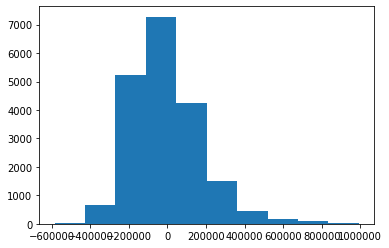

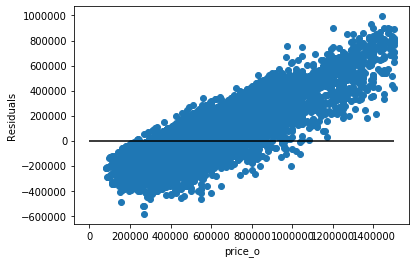

In [373]:
plot_residuals(new_df, res)

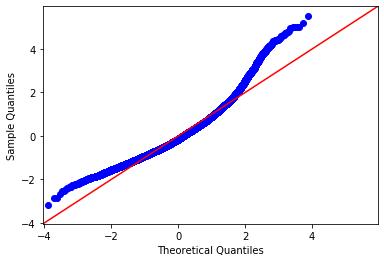

In [387]:
fig = sm.graphics.qqplot(res.resid, dist=stats.norm, line='45', fit=True)